# Load and install modules


In [1]:
!pip install -q transformers
!pip install -q tensorflow
!pip install -U sentence-transformers

# need to upgrade numpy for hdbscan
# !pip install numpy==1.16.0

# install this first before hdbscan
!pip install Cython

!pip install hdbscan

!pip install -q umap-learn

     |████████████████████████████████| 3.1 MB 26.0 MB/s 
     |████████████████████████████████| 3.3 MB 70.4 MB/s 
     |████████████████████████████████| 596 kB 54.2 MB/s 
     |████████████████████████████████| 61 kB 474 kB/s 
     |████████████████████████████████| 895 kB 56.9 MB/s 
     |████████████████████████████████| 78 kB 6.0 MB/s 
     |████████████████████████████████| 1.2 MB 41.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=10e9d3959d08bdc2f23a189a56773b755b282b31663b0533d05143f6c0e8b3e6
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
     |████████████████████████████████| 6.4 MB 35.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size

In [2]:

from __future__ import absolute_import, division, print_function, unicode_literals
import functools
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans


import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.manifold import TSNE

# from sklearn.decomposition import PCA
# from sklearn import metrics
# from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
# from transformers import pipeline
from google.colab import output

In [5]:

import glob
import pandas as pd
import numpy as np

import re

import os
import hdbscan

from numpy import asarray
from numpy import save
from numpy import load
from google.colab import files
from google.colab import drive
drive.mount('/content/drive' ,force_remount=True)
os.chdir("drive/MyDrive/vaccine/data/")




Mounted at /content/drive


['second_batch_combined.csv',
 'first_batch_complete.csv',
 'get_metadata.py',
 'output',
 'train.txt',
 'autoencoder_decoder',
 'train_mlm.py',
 'train_text_embeddings.npy',
 'autoencoder_decoder tanh SGD',
 'autoencoder_decoder selu SGD',
 'autoencoder_decoder tanh SGD lr001',
 'hdbscan cluster labels manhattan grp 20.npy',
 'archive.zip',
 'archive.zip (Unzipped Files)',
 'covid-19_vaccine_tweets_with_sentiment.csv',
 'fine_tune_sentimnet',
 'baseline_sentiment_scores.npy',
 'test_text_embeddings.npy',
 'best_model_sent_pred.npy',
 'best_model_sentiment_scores.npy',
 'test_data_best_model_sentiment_scores.npy',
 'test_data_best_model_sent_pred.npy',
 'train_text_embeddings_with_sentiment.npy',
 'autoencoder_decoder tanh SGD lr001 with sentiment',
 'hdbscan cluster labels manhattan grp 20 with sentiment.npy',
 'TEST hdbscan cluster labels manhattan grp 20 with sentiment.npy',
 'tsne.png',
 'umap.png',
 'umap 50000.png',
 'test_FULL_data_best_model_sentiment_scores.npy',
 'test_FULL_d

In [3]:

from keras.models import Model
from keras.layers import Dense, Activation

from tensorflow.keras.optimizers import Adam, SGD
from keras.models import Sequential
from keras import backend as K

import matplotlib.pyplot as plt


In [6]:
!pwd

/content/drive/MyDrive/vaccine/data


##Sentence embedding trainer from  https://github.com/UKPLab/sentence-transformers/blob/master/examples/unsupervised_learning/MLM/train_mlm.py

In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
from transformers import DataCollatorForLanguageModeling, DataCollatorForWholeWordMask
from transformers import Trainer, TrainingArguments
import sys
import gzip
from datetime import datetime

if len(sys.argv) < 3:
    print("Usage: python train_mlm.py model_name data/train_sentences.txt [data/dev_sentences.txt]")
    exit()

model_name = sys.argv[1]
per_device_train_batch_size = 64

save_steps = 1000               #Save model every 1k steps
num_train_epochs = 3            #Number of epochs
use_fp16 = True                #Set to True, if your GPU supports FP16 operations
max_length = 55               #Max length for a text input
do_whole_word_mask = True       #If set to true, whole words are masked
mlm_prob = 0.15                 #Probability that a word is replaced by a [MASK] token

# Load the model
model = AutoModelForMaskedLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


output_dir = "output/{}-{}".format(model_name.replace("/", "_"),  datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
print("Save checkpoints to:", output_dir)


##### Load our training datasets

train_sentences = []
train_path = sys.argv[2]
with gzip.open(train_path, 'rt', encoding='utf8') if train_path.endswith('.gz') else  open(train_path, 'r', encoding='utf8') as fIn:
    for line in fIn:
        line = line.strip()
        if len(line) >= 10:
            train_sentences.append(line)

print("Train sentences:", len(train_sentences))

dev_sentences = []
if len(sys.argv) >= 4:
    dev_path = sys.argv[3]
    with gzip.open(dev_path, 'rt', encoding='utf8') if dev_path.endswith('.gz') else open(dev_path, 'r', encoding='utf8') as fIn:
        for line in fIn:
            line = line.strip()
            if len(line) >= 10:
                dev_sentences.append(line)

print("Dev sentences:", len(dev_sentences))

#A dataset wrapper, that tokenizes our data on-the-fly
class TokenizedSentencesDataset:
    def __init__(self, sentences, tokenizer, max_length, cache_tokenization=False):
        self.tokenizer = tokenizer
        self.sentences = sentences
        self.max_length = max_length
        self.cache_tokenization = cache_tokenization

    def __getitem__(self, item):
        if not self.cache_tokenization:
            return self.tokenizer(self.sentences[item], add_special_tokens=True, truncation=True, max_length=self.max_length, return_special_tokens_mask=True)

        if isinstance(self.sentences[item], str):
            self.sentences[item] = self.tokenizer(self.sentences[item], add_special_tokens=True, truncation=True, max_length=self.max_length, return_special_tokens_mask=True)
        return self.sentences[item]

    def __len__(self):
        return len(self.sentences)

train_dataset = TokenizedSentencesDataset(train_sentences, tokenizer, max_length)
dev_dataset = TokenizedSentencesDataset(dev_sentences, tokenizer, max_length, cache_tokenization=True) if len(dev_sentences) > 0 else None


##### Training arguments

if do_whole_word_mask:
    data_collator = DataCollatorForWholeWordMask(tokenizer=tokenizer, mlm=True, mlm_probability=mlm_prob)
else:
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=mlm_prob)


--2021-11-26 19:52:16--  https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/examples/unsupervised_learning/MLM/train_mlm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4384 (4.3K) [text/plain]
Saving to: ‘train_mlm.py’

train_mlm.py        100%[===================>]   4.28K  --.-KB/s    in 0s      

2021-11-26 19:52:16 (10.1 MB/s) - ‘train_mlm.py’ saved [4384/4384]



In [ ]:

training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=num_train_epochs,
    evaluation_strategy="steps" if dev_dataset is not None else "no",
    per_device_train_batch_size=per_device_train_batch_size,
    eval_steps=save_steps,
    save_steps=save_steps,
    logging_steps=save_steps,
    save_total_limit=1,
    prediction_loss_only=True,
    fp16=use_fp16
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset
)

print("Save tokenizer to:", output_dir)
tokenizer.save_pretrained(output_dir)

trainer.train()

print("Save model to:", output_dir)
model.save_pretrained(output_dir)

print("Training done")
# !wget https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/examples/unsupervised_learning/MLM/train_mlm.py -O  train_mlm.py


# Next Section

In [ ]:
# os.chdir("drive/MyDrive/vaccine/data/")

# # data = json.load(open("combined.csv", "r"))

# def get_hashtag_pct(df):
#   return df[df["hashtags"] != ''].shape[0]/df.shape[0] 
# # df['hashtags'].unique().shape

In [ ]:
# !pwd


/content/drive/My Drive/vaccine/data


In [8]:
combined_df = pd.DataFrame(columns= ['created_at', 'id', 'text', 'hashtags', 'word_count'])
for file in glob.glob('second*.csv*'):
  df = pd.read_csv(file,na_filter=False)
  print(file,df.shape)
  # combined_df = pd.concat([combined_df,df], ignore_index=True)
  df.shape

second_batch_combined.csv (1480544, 5)


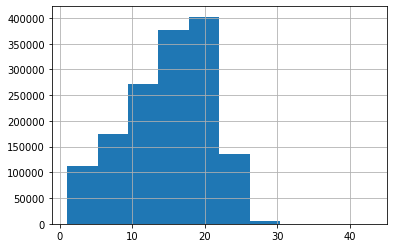

In [9]:
df['word_count'].hist()
# df['text'].to_csv('test_text_full.txt', sep=' ', index=False, header=False)

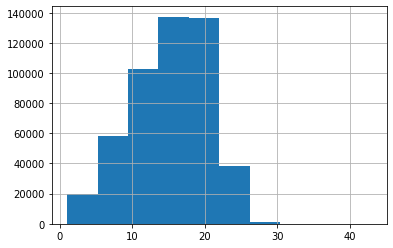

In [10]:
test_df = df.loc[df['text'].str.contains("vacc|vax", case = False )]
test_df.iloc[test_df['word_count'].idxmax(),:]
test_df.shape
test_df['word_count'].hist()

# test_df['text'].to_csv('test_text_full.txt', sep=' ', index=False, header=False)

In [136]:
test_df.reset_index(inplace= True)

In [ ]:
test_df.loc[test_df['word_count'] < 3]

created_at  ...  word_count
1299     2017-03-25 09:01:34+00:00  ...           2
1366     2017-03-21 11:00:54+00:00  ...           2
1846     2017-03-21 09:42:36+00:00  ...           2
2942     2017-03-21 20:53:15+00:00  ...           2
3262     2017-03-22 10:00:37+00:00  ...           2
...                            ...  ...         ...
1479609  2020-12-17 11:13:56+00:00  ...           2
1479845  2020-12-18 06:42:36+00:00  ...           1
1480019  2020-12-16 21:33:21+00:00  ...           1
1480187  2020-12-15 00:37:58+00:00  ...           2
1480239  2020-12-13 14:33:40+00:00  ...           1

[3551 rows x 5 columns]

In [ ]:
# !python train_mlm.py sadakmed/distiluse-base-multilingual-cased-v2 train.txt

# New Section

In [ ]:

df['word_count'][df['word_count'].idxmax()]
df['text'][df['word_count'].idxmax()]

'He seem tested positive . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . HIV'

In [ ]:
df['word_count'][df['word_count'].idxmax()]
df['text'][df['word_count'].idxmax()]

'He seem tested positive . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . HIV'

In [ ]:
# glued_data = pd.DataFrame()
# for file in glob.glob('/content/drive/MyDrive/vaccine/shuffled2/trimmed json files/*.csv'):
#   if 'trimmed_201220_201226.csv' not in file:
#       df = pd.read_csv(file, na_filter= False)
#       glued_data = pd.concat([glued_data,df],axis=0, ignore_index= True)


# glued_data.shape



(1732535, 5)

In [ ]:
get_hashtag_pct(df)

0.1045660727605476

# create embeddings from  pre trained sentence model

In [9]:
test_trimmed_text = test_df['text'].copy()

# trimmed_text = df['text'].copy()
# trimmed_hashtags = trimmed_df['hashtags'].copy
# AutoModel.from_pretrained('sadakmed_distiluse-base-multilingual-cased-v2-2021-11-27_16-23-03')
embedder = SentenceTransformer('output/sadakmed_distiluse-base-multilingual-cased-v2-2021-11-28_20-06-32' )
embedder.max_seq_length = 43

Some weights of the model checkpoint at output/sadakmed_distiluse-base-multilingual-cased-v2-2021-11-28_20-06-32 were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
test_trimmed_text = load(test.txt)

/content/drive/My Drive/vaccine/data


In [10]:

test_text_embeddings = embedder.encode(list(test_trimmed_text))


In [11]:
# Run this the first time
# save('train_text_embeddings.npy', text_embeddings)
save('test_text_FULL_embeddings.npy',test_text_embeddings)
test_text_embeddings[0]

array([-2.69198343e-02,  4.17161845e-02,  2.32541049e-03,  1.13476289e-03,
        4.61002961e-02,  5.57054132e-02,  1.89827867e-02,  6.90089166e-02,
       -8.24766513e-03,  6.92333430e-02, -4.26971801e-02,  7.55787315e-03,
       -1.10446932e-02,  1.04852198e-02,  5.14061451e-02,  2.37549841e-02,
        1.70350093e-02, -1.09947389e-02,  5.37374616e-02, -2.99483482e-02,
       -3.92558835e-02,  4.03185235e-03,  4.95414771e-02,  3.03802826e-02,
        2.71534342e-02, -1.00530311e-02,  1.90259945e-02,  6.08917885e-03,
       -1.52101265e-02, -4.98035084e-03,  2.03615557e-02, -3.92388133e-03,
        3.27559188e-02,  5.12991287e-02,  4.66044946e-03,  1.79736631e-03,
        5.54897683e-03, -1.34361098e-02, -1.53297409e-02, -4.21119742e-02,
       -2.83749998e-02, -4.50048298e-02, -5.54136224e-02, -3.29625309e-02,
       -6.46451674e-03, -3.94121185e-02, -1.12311933e-02, -3.79735604e-02,
        1.66081358e-02, -9.46407579e-03, -5.28540509e-03,  2.34256741e-02,
       -3.62183084e-03,  

# Load embeddings


In [ ]:
# train_data = text_embeddings

NameError: ignored

In [3]:
#access the data for later

# load array
train_data = load('train_text_embeddings.npy')
train_sentiment = load('best_model_sentiment_scores.npy')
# test_data = load('test_text_embeddings.npy')
# print the array
(train_data.shape), (train_sentiment.shape) 
new_train = np.append(train_data, train_sentiment,axis =1)
new_train.shape

((1832669, 768), (1832669, 3))

In [5]:

save('train_text_embeddings_with_sentiment.npy', new_train)
# save('test_text_embeddings.npy',text_embeddings)
# text_embeddings[0]

In [8]:
new_train[0].shape
instances, input_features = new_train[0:1466135].shape
train_dataset = new_train[0:1466135]
val_dataset = new_train[1466135:]

type(train_dataset), type(val_dataset)

(numpy.ndarray, numpy.ndarray)

In [9]:
model = Sequential()
model.add(Dense(128, activation='tanh', input_shape=(input_features,)))
model.add(Dense(32, activation='tanh'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(input_features, activation='sigmoid'))

In [10]:

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

model.compile(optimizer=SGD(learning_rate=lr_schedule),loss='binary_crossentropy')#, optimizer='SGD')

model.fit(train_dataset,train_dataset,  epochs=10, validation_data=(val_dataset, val_dataset))

Epoch 1/10
45817/45817 [==============================] - 131s 3ms/step - loss: 0.6597 - val_loss: 0.5707
Epoch 2/10
45817/45817 [==============================] - 124s 3ms/step - loss: 0.3795 - val_loss: 0.2332
Epoch 3/10
45817/45817 [==============================] - 123s 3ms/step - loss: 0.1703 - val_loss: 0.1277
Epoch 4/10
45817/45817 [==============================] - 122s 3ms/step - loss: 0.1060 - val_loss: 0.0895
Epoch 5/10
45817/45817 [==============================] - 123s 3ms/step - loss: 0.0793 - val_loss: 0.0709
Epoch 6/10
45817/45817 [==============================] - 121s 3ms/step - loss: 0.0652 - val_loss: 0.0602
Epoch 7/10
45817/45817 [==============================] - 123s 3ms/step - loss: 0.0566 - val_loss: 0.0533
Epoch 8/10
45817/45817 [==============================] - 122s 3ms/step - loss: 0.0509 - val_loss: 0.0486
Epoch 9/10
45817/45817 [==============================] - 122s 3ms/step - loss: 0.0469 - val_loss: 0.0452
Epoch 10/10
45817/45817 [=====================

In [17]:
model.save('autoencoder_decoder tanh SGD lr001 with sentiment')

INFO:tensorflow:Assets written to: autoencoder_decoder tanh SGD lr001 with sentiment/assets


#Load model, compress and HDBSCAN


In [12]:
model = tf.keras.models.load_model('autoencoder_decoder tanh SGD lr001')

def compress(model, x_test):
    output = K.function([model.layers[0].input], [model.layers[1].output])
    compressed = output([x_test])
    
    return compressed

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               98432     
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 768)               99072     
                                                                 
Total params: 205,856
Trainable params: 205,856
Non-trainable params: 0
_________________________________________________________________


In [16]:
dataset = load("test_text_embeddings.npy")
compressed_layer = compress(model,dataset)
test = compressed_layer[0]
sent_score = load('test_data_best_model_sent_pred.npy')

In [17]:
test.shape, sent_score.shape

((495065, 32), (495065,))

In [20]:
def random_rows(npy_embeddingsinput, npy_sentscore):
# Select 80000 random indices  
  number_of_rows = npy_embeddingsinput.shape[0]
  random_indices = np.random.choice(number_of_rows, size=80000, replace=False)


  return (random_indices ,npy_embeddingsinput[random_indices, :],  np.delete(npy_embeddingsinput, random_indices, axis=0), npy_sentscore[random_indices, ], np.delete(npy_sentscore, random_indices, axis=0))


In [22]:


indices, data , validation, test_sent, validation_sent = random_rows(test,sent_score)
indices.shape, data.shape , validation.shape, test_sent.shape, validation_sent.shape


((80000,), (80000, 32), (415065, 32), (80000,), (415065,))

In [137]:
data_df = test_df.loc[test_df.index.isin(indices)]
# df.loc[~df.index.isin(t)]
val_df = test_df.loc[~test_df.index.isin(indices)]

In [138]:
data_df.shape,val_df.shape

((80000, 6), (415065, 6))

In [30]:

clusterer = hdbscan.HDBSCAN(metric=  'manhattan', min_cluster_size=20,prediction_data=True)

In [7]:
# clusterer = hdbscan.HDBSCAN(metric="cosine",
#                             algorithm="generic",  min_cluster_size=40,prediction_data=True)
# # result = clusterer.fit_predict(data)

In [31]:
clusterer = hdbscan.HDBSCAN(metric=  'manhattan', min_cluster_size=20,prediction_data=True)
clusterer.fit_predict(data)
clusterer.labels_.max()
data_group = clusterer.labels_
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/7/7a/Bongo_sound.wav").play()')

24

In [33]:

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/7/7a/Bongo_sound.wav").play()')

In [34]:
np.unique(clusterer.labels_)

data_group = clusterer.labels_

## HDBscan Predict 

In [98]:
test_labels, strengths =hdbscan.approximate_predict(clusterer, validation)
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/7/7a/Bongo_sound.wav").play()')

In [149]:
# save('hdbscan cluster labels manhattan grp 20 with sentiment',clusterer.labels_)

# test_labels.shape
# test_labels.max()
# val_df['cluster']= pd.Series(np.array(test_labels))
# val_df['sentiment'] = pd.Series(validation_sent)
# val_cluster = val_df['cluster'].unique()
# labels = (val_cluster >=0)
val_df.head()

index                created_at  ...  cluster sentiment
0      4 2017-03-20 08:09:36+00:00  ...     -1.0       0.0
3     19 2017-03-20 16:50:53+00:00  ...     -1.0       0.0
4     26 2017-03-25 16:14:27+00:00  ...     -1.0       1.0
5     27 2017-03-22 21:40:11+00:00  ...     -1.0       1.0
6     28 2017-03-24 09:07:15+00:00  ...     -1.0       1.0

[5 rows x 8 columns]

In [166]:
val_df.loc[:,'created_at']= pd.to_datetime(val_df.loc[:,'created_at'],infer_datetime_format = True)
val_df.loc[:,'week'] = val_df.loc[:,'created_at'].dt.isocalendar().week
val_df.loc[:,'year'] = val_df.loc[:,'created_at'].dt.year
val_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


index                created_at                  id  ... sentiment week    year
0     4 2017-03-20 08:09:36+00:00  845670222543699968  ...         0   12  2017.0
3    19 2017-03-20 16:50:53+00:00  844439175273332736  ...         0   12  2017.0
4    26 2017-03-25 16:14:27+00:00  843389557810847745  ...         1   12  2017.0
5    27 2017-03-22 21:40:11+00:00  844110285304676352  ...         1   12  2017.0
6    28 2017-03-24 09:07:15+00:00  845419972528672768  ...         1   12  2017.0

[5 rows x 10 columns]

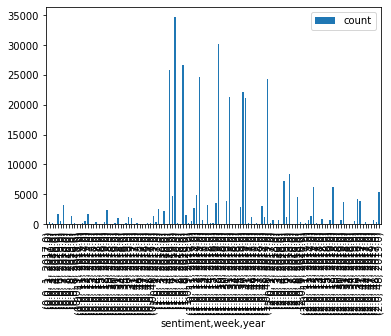

In [170]:
grouped = val_df.groupby(['sentiment','week',"year"]).sentiment.agg(['count'])

grouped.plot.bar()


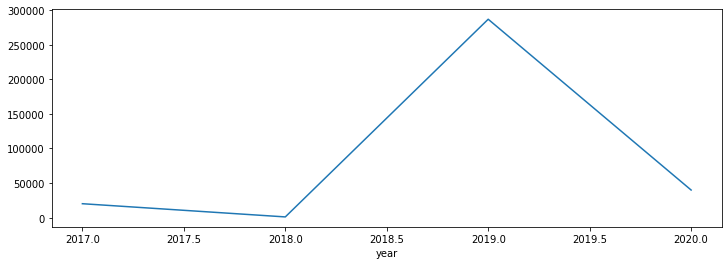

In [182]:
fig, axs = plt.subplots(figsize=(12, 4))
val_df.groupby([val_df["created_at"].dt.isocalendar().year])["sentiment"].count().plot(kind='line', rot=0, ax=axs)

#  val_df.columns
# test_data = load('test_text_embeddings.npy')
# test_sentiment = load('test_data_best_model_sentiment_scores.npy')
# # print the array
# (test_data.shape), (test_sentiment.shape) 

In [33]:

test = np.append(test_data, test_sentiment,axis =1)
test.shape

(495065, 771)

In [93]:

# number_of_rows = compressed_layer[0].shape[0]
# random_indices = np.random.choice(number_of_rows, size=50000, replace=False)
# # Select 5000 random indices

# data  = compressed_layer[0][random_indices, :]

In [94]:
compressed_layer = autoencode(model,test)
# data = compressed_layer[0][:50000]

In [95]:
clusterer.fit(data)
clusterer.labels_.max()

3

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


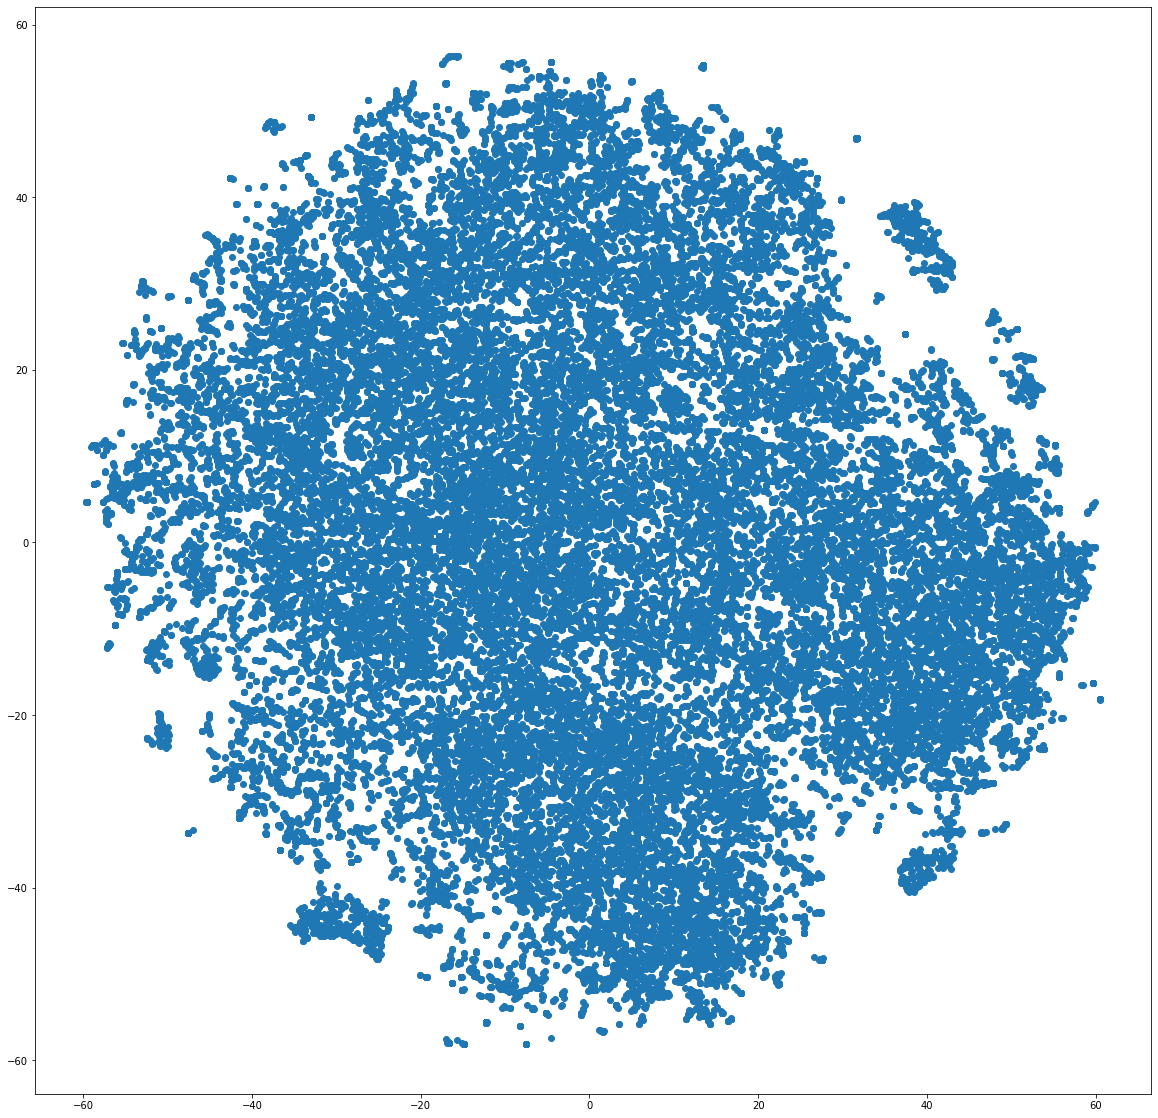

In [83]:
from sklearn.manifold import TSNE
projection = TSNE().fit_transform(data)
plt.figure(figsize=(20,20))
plt.scatter(*projection.T)
plt.savefig('tsne', bbox_inches="tight")

In [35]:
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

ModuleNotFoundError: ignored

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# plt.scatter(*data.T)

In [61]:
import seaborn as sns
pal = sns.color_palette("magma", as_cmap=True)
# colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_,clusterer.probabilities_)]
plt.scatter(data.T[0], data.T[1], c=pal, **plot_kwds);

NameError: ignored

In [ ]:

save('TEST hdbscan cluster labels manhattan grp 20 with sentiment',clusterer.labels_)

In [36]:
labelss = hdbscan.HDBSCAN(metric=  'manhattan', min_cluster_size=20,prediction_data=True).fit_predict(data)
# clusterer.fit_predict(data)
# clusterer.labels_.max()
# data_group = clusterer.labels_
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/7/7a/Bongo_sound.wav").play()')
# labels = hdbscan.HDBSCAN(
#     min_samples=10,
#     min_cluster_size=500,
# ).fit_predict(clusterable_embedding)

In [70]:
clustered = (labelss >= 0)
clustered.shape
# import matplotlib.pyplot as plt
# import pandas as pd
# x = {'speed': [10, 15, 20, 18, 19],
#      'meters' : [122, 150, 190, 230, 300],
#      'type': ['phone', 'phone', 'gps', 'gps', 'car'],
#      'weight': [0.2, 0.3, 0.1, 0.85, 0.0],
#      'old': [1, 2, 4, 5, 8]}

# m = pd.DataFrame(x)
# mkr_dict = {'gps': '_', 'phone': '+', 'car': 'o'}
# for kind in mkr_dict:
#     print(kind)
#     d = m[m.type==kind]
#     print(d)
#     plt.scatter(d.meters, d.speed, 
#                 s = 100, 
#                 c = d.old, 
#                 marker = mkr_dict[kind])
# plt.show()

(80000,)

#UMAP

In [119]:

import umap.umap_ as umap
import seaborn as sns
def draw_umap(data,c,sent_score,sentiment_score =False ,n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    clustered = (c >=0)

    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        low_memory=True
    )
    
    u = fit.fit_transform(data);
    fig = plt.figure(figsize = (16,16), dpi = 400)
    
    if sentiment_score == False:
    
      if n_components == 2:
          ax = fig.add_subplot(111)
          scatter = ax.scatter(u[clustered,0], u[clustered,1], c=c[clustered],  s=40, alpha =.6)
          legend1 = ax.legend(*scatter.legend_elements(),
                      loc="lower left", title="Classes", fontsize =14)
          ax.add_artist(legend1)
          # plt.savefig( f'{n_neighbors} n neigbors with distance {min_dist} {title}.jpeg', bbox_inches="tight", pad_inches =1);
      if n_components == 3:
          ax = fig.add_subplot(111, projection='3d')
          ax.scatter(u[clutered,0], u[clustered,1], u[clustered,2], c=c[clustered], s=40,alpha =.6 )
          # plt.savefig(f'{n_neighbors} n neigbors with distance {min_dist} {title}.jpeg', bbox_inches="tight", pad_inches =1);
    else:
      if n_components == 2:
          ax = fig.add_subplot(111)
          scatter = ax.scatter(u[clustered,0], u[clustered,1], c=sent_score[clustered],  s=40, alpha =.5)
          legend1 = ax.legend(*scatter.legend_elements(),
                      loc="lower left", title="Classes", fontsize =14)
          ax.add_artist(legend1)
          plt.tight_layout()
    plt.tight_layout()
    plt.title(title, fontsize=18)
    plt.savefig(f'{n_neighbors} n neigbors with distance {min_dist} {title}.jpeg', bbox_inches="tight");
    




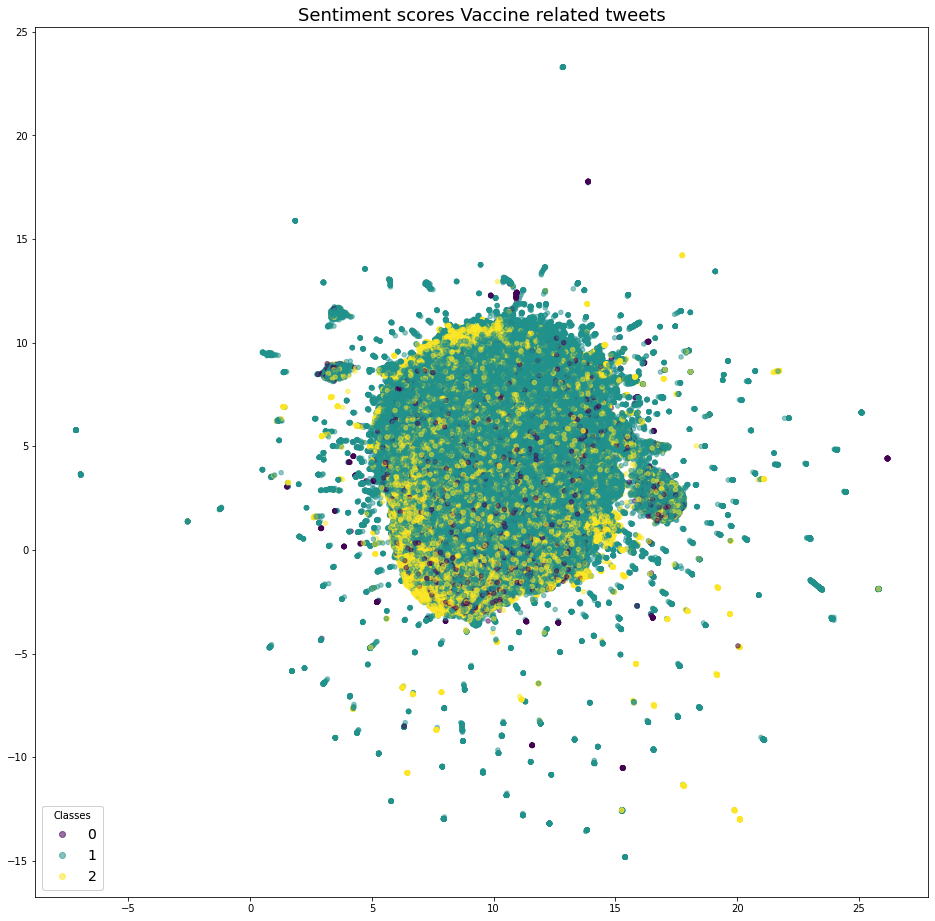

In [108]:
draw_umap(validation,validation_sent, n_neighbors=25,min_dist=0.25, n_components=2, metric='cosine',title= 'Sentiment scores Vaccine related tweets')

In [110]:
def multiple_umaps(data,data_group,test_sent):
  draw_umap(data,data_group,test_sent, n_neighbors=25,min_dist=0.5, n_components=2, metric='cosine',title= 'UMAP grouping of tweets related to vaccines.')
  draw_umap(data,data_group,test_sent,sentiment_score=True, n_neighbors=25,min_dist=0.5, n_components=2, metric='cosine',title= 'Sentiment of tweets related to vaccines.')

  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/7/7a/Bongo_sound.wav").play()')

In [120]:
multiple_umaps(data,data_group,test_sent)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
multiple_umaps(validation,test_labels,validation_sent)

In [96]:
embedding = reducer.fit_transform(data)
embedding.shape

(50000, 2)

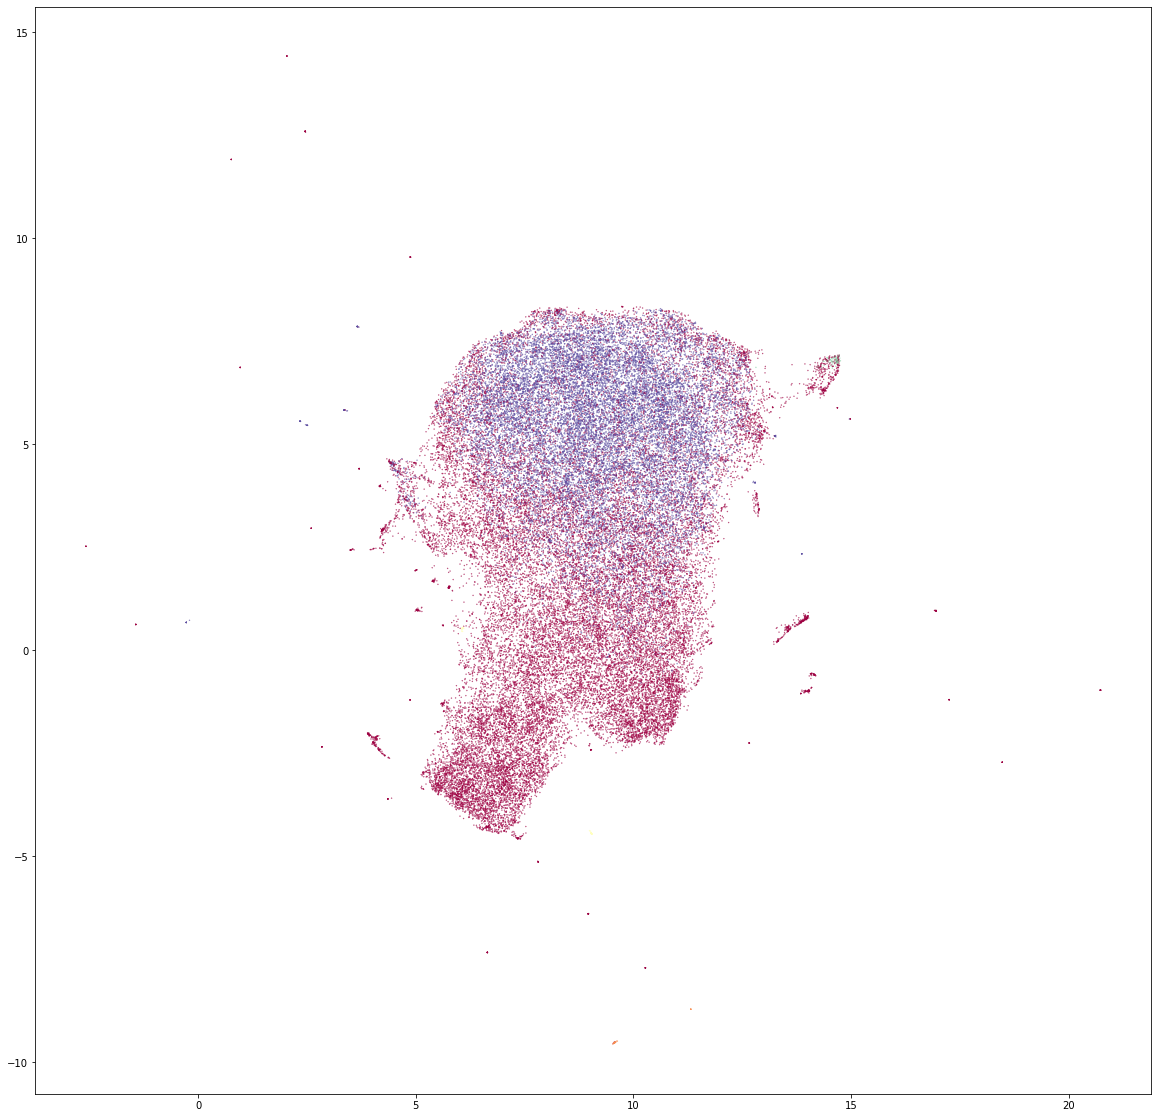

In [97]:
plt.figure(figsize=(20,20))


plt.scatter(embedding[:, 0], embedding[:, 1], c=clusterer.labels_, s=0.1, cmap='Spectral')
plt.savefig('umap 50000', bbox_inches="tight");

In [46]:
sent_score[]

0

In [60]:
mkr_dict = {0: '_', 1: 'o', 2: '+'}

In [73]:
test_sent[clustered] 
np.array(test_sent == 0).

array([1, 1, 2, ..., 2, 1, 2])

In [84]:
np.array(map(str, test_sent))
# 
# 
# print(a)

array(<map object at 0x7f887dbb0310>, dtype=object)

In [88]:
string_sent =np.char.mod('%d', test_sent)
string_sent = np.where(string_sent == "1",'o', string_sent)
string_sent = np.where(string_sent == "0",'_', string_sent)
string_sent = np.where(string_sent =='2', '+',string_sent )
string_sent[:15]

array(['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', '_', 'o',
       '+', 'o'], dtype='<U1')

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE()
X_valid_2D = tsne.fit_transform(compressed_layer[0])
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


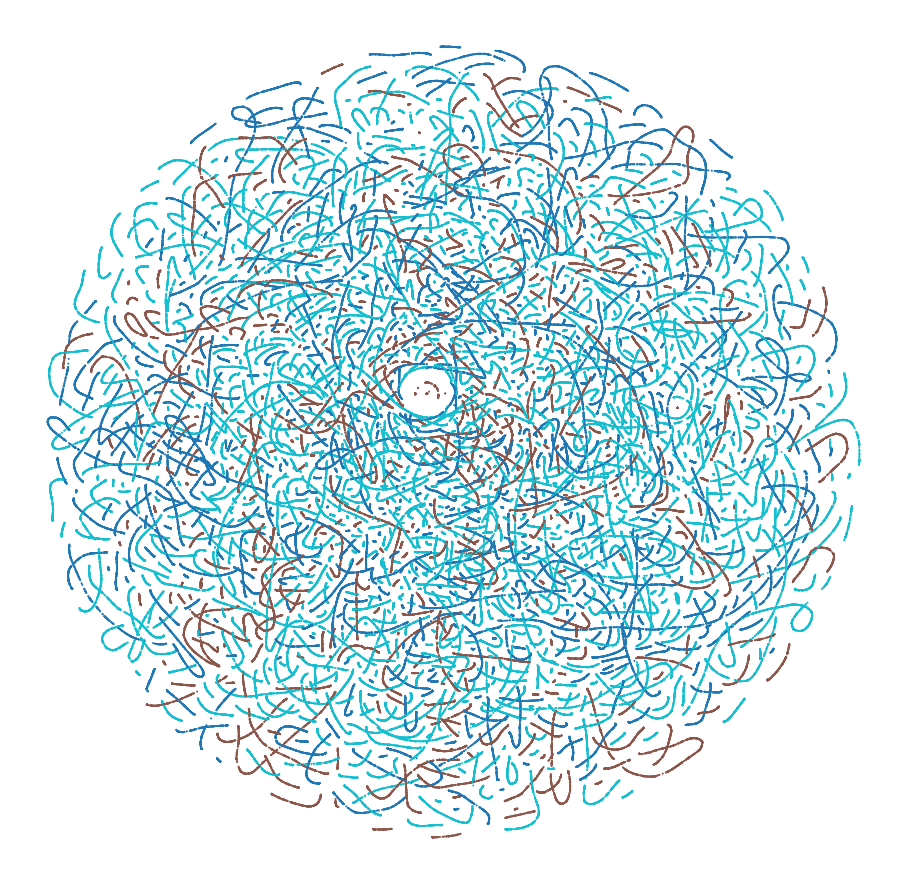

In [ ]:
num_clusters = 3
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(compressed_layer[0])
cluster_assignment = clustering_model.labels_
plt.figure(figsize=(16,16))
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=cluster_assignment , s=1, cmap="tab10")
plt.axis("off")
plt.show()

In [ ]:
a

In [ ]:


pca_text.shape

(44154, 50)

In [ ]:

tsne = TSNE()
X_valid_2D = tsne.fit_transform(pca_text)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


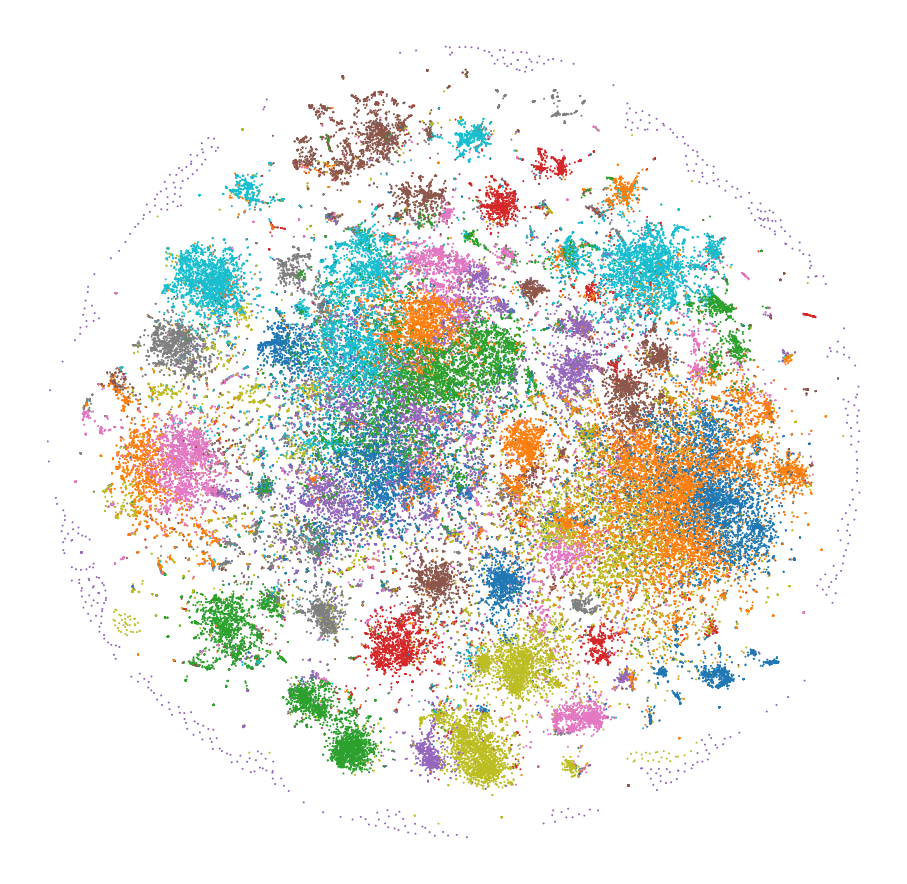

In [ ]:
plt.figure(figsize=(16,16))
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=cluster_assignment , s=1, cmap="tab10")
plt.axis("off")
plt.show()

In [ ]:
!pip install -q umap-learn[plot]
!pip install -q holoviews
!pip install -U ipykernel
!pip install configs



     |████████████████████████████████| 86 kB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 29.7 MB/s 
     |████████████████████████████████| 15.8 MB 34.1 MB/s 
     |████████████████████████████████| 76 kB 6.1 MB/s 
     |████████████████████████████████| 132 kB 74.7 MB/s 
     |████████████████████████████████| 802 kB 67.5 MB/s 
     |████████████████████████████████| 793 kB 29.0 MB/s 
     |████████████████████████████████| 793 kB 66.9 MB/s 
     |████████████████████████████████| 791 kB 73.4 MB/s 
     |████████████████████████████████| 786 kB 71.2 MB/s 
     |████████████████████████████████| 779 kB 68.5 MB/s 
     |████████████████████████████████| 778 kB 69.0 MB/s 
     |████████████████████████████████| 776 kB 70.1 MB/s 
     |████████████████████████████████| 769 kB 71.6 MB/s 
     |████████████████████████████████| 766 kB 69.6 MB/s 
     |████████████████████████████████| 1.0 MB 75.6 MB/s 
     |████████████████████████████████| 722 kB 80.5 MB/s 
     |███████████

In [ ]:
import umap

from configs import config as cf


clusterable_embedding = umap.UMAP(
    n_neighbors=20,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(compressed_layer[0])

ModuleNotFoundError: ignored

In [ ]:
plt.figure(figsize=(16,16))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=cluster_assignment, s=0.1, cmap='Spectral' );

In [ ]:
clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(trimmed_text[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from transformers import pipeline
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
sentiment_task("Huggingface es lo mejor! Awesome library 🤗😎")

Downloading:   0%|          | 0.00/841 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

[{'label': 'Positive', 'score': 0.9343641400337219}]

In [ ]:
Cluster1 = ['How many died under H1N1? And how many have died under COVID-19? Then STFU! You have so many death…',
            'Attenzione circola un brutto virus. I sintomi più comuni sono: Le mascherine sono dannose È solo una banale influen…',
            'Researchers take immunooncology cue to improve efficacy/protection by antibodies vs viral infection Engineer Fc…', 
            'Responden sonorenses a campaña de vacunación contra influenza: Salud Sonora', 
            'In Donald Trump, we have discovered what would happen if Typhoid Mary had been the boss instead of the the cook. An…', 
            'To all these people who compare Covid-19 to a seasonal Flu I ask, “How many of you go to hospital for 7…', 
            'delireum is a flu symtom !', '472 cases average per year before the vaccine wa…', 
            "No idea what is going on but I'm going to do my best to spread awareness about $RSR &amp; $RSV at all times! 😂",
            'Thank u C4 🙌. This is why they people dont trust- informedchoice…', 
            'Last year’s flu season was responsible for millions of cases. With COVID-19 still very much prevalent, this could b…', 
            'Without a vaccine what next? Is a COVID death from it or with it? Move COVID patients to nightingal…', 
            'Regeneron monoclonal antibody therapy "REGN10933 and REGN10987" effectively acts as: Treatment Cure and…', 
            'Vaccine opportunity depends on govt role, price', 'Intent to get a COVID-19 vaccine has fallen from 72% in May to 51% in September. VPDebate', 
            'China Joins WHO-Backed Covid-19 Vaccine Initiative, As The U.S. Stays Out &gt;&gt;&gt;…',
            'Fetal Cells from aborted babies are used in the flu vaccine', 
            'Long COVID is no different to what patients experience after severe influenza, pneumonia, glandular fe…']



In [ ]:
sentiment_task(Cluster1)

[{'label': 'Negative', 'score': 0.921519935131073},
 {'label': 'Negative', 'score': 0.8946983218193054},
 {'label': 'Neutral', 'score': 0.6035472750663757},
 {'label': 'Neutral', 'score': 0.7936980128288269},
 {'label': 'Neutral', 'score': 0.4582768380641937},
 {'label': 'Negative', 'score': 0.6911517381668091},
 {'label': 'Negative', 'score': 0.8156061768531799},
 {'label': 'Neutral', 'score': 0.7790004014968872},
 {'label': 'Positive', 'score': 0.5137982368469238},
 {'label': 'Positive', 'score': 0.36517900228500366},
 {'label': 'Negative', 'score': 0.7275332808494568},
 {'label': 'Negative', 'score': 0.7402677536010742},
 {'label': 'Neutral', 'score': 0.7496735453605652},
 {'label': 'Neutral', 'score': 0.8451706171035767},
 {'label': 'Neutral', 'score': 0.8074036240577698},
 {'label': 'Neutral', 'score': 0.6920478343963623},
 {'label': 'Neutral', 'score': 0.8002303838729858},
 {'label': 'Negative', 'score': 0.5506162047386169}]

In [ ]:
sentiment_task(Cluster2)

[{'label': 'Neutral', 'score': 0.8144306540489197},
 {'label': 'Neutral', 'score': 0.6123733520507812},
 {'label': 'Negative', 'score': 0.9446523189544678},
 {'label': 'Neutral', 'score': 0.4920330345630646},
 {'label': 'Negative', 'score': 0.7949302792549133},
 {'label': 'Negative', 'score': 0.9074919819831848},
 {'label': 'Negative', 'score': 0.4882653057575226},
 {'label': 'Positive', 'score': 0.6052323579788208},
 {'label': 'Negative', 'score': 0.8718031644821167},
 {'label': 'Negative', 'score': 0.5787925720214844},
 {'label': 'Positive', 'score': 0.6190054416656494},
 {'label': 'Positive', 'score': 0.5780251622200012},
 {'label': 'Negative', 'score': 0.8936976194381714},
 {'label': 'Negative', 'score': 0.854710578918457},
 {'label': 'Negative', 'score': 0.6580137610435486},
 {'label': 'Negative', 'score': 0.8346595168113708},
 {'label': 'Negative', 'score': 0.9086468815803528},
 {'label': 'Neutral', 'score': 0.6645505428314209}]

In [ ]:
sentiment_task(Cluster3)

[{'label': 'Negative', 'score': 0.7625883221626282},
 {'label': 'Negative', 'score': 0.6238764524459839},
 {'label': 'Positive', 'score': 0.7142613530158997},
 {'label': 'Negative', 'score': 0.5917131304740906}]

In [101]:
!pip install bertopic


     |████████████████████████████████| 57 kB 4.8 MB/s 
  Using cached numpy-1.21.4-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
     |████████████████████████████████| 636 kB 32.5 MB/s 
     |████████████████████████████████| 13.2 MB 59.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
datasc

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(language="multilanguage", calculate_probabilities=True, verbose=True)
# topics, probs = topic_model.fit_transform(docs)

In [102]:
from sklearn.datasets import fetch_20newsgroups
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']
docs

["\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n",
 'My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:\n\n  - Diamond Stealth Pro Local Bus\n\n  - Orchid Farenheit 1280\n\n  - ATI Graphics Ultra Pro\n\n  - Any other high-per